In [56]:
import pandas as pd
df = pd.read_html('https://www.basketball-reference.com/playoffs/series.html')[0]

In [58]:
dfc = df.copy()

# Fix columns
dfc.columns = [c[0] if 'Unnamed' not in c[0] else c[1] for c in dfc.columns]
dfc = dfc.drop(columns=['Favorite', 'Underdog', 'Unnamed: 4_level_1', 'Unnamed: 7_level_1', 'Unnamed: 10_level_1'])
dfc.columns = ['Yr', 'Lg', 'Series', 'Date', 'Winner', 'Ww', 'Loser', 'Lw']

# Drop all bad rows
dfc = dfc.dropna()
num_to_jump = len(dfc[dfc.Yr == "2020"])
dfc = dfc[dfc.Yr != "2020"] # 2020 not complete yet
dfc = dfc.reset_index(drop=True)

# Add Won? columns
dfc['Won 1?'] = "X"
dfc['Won 2?'] = "X"
dfc['Won 3?'] = "X"
dfc['Won 4?'] = "X"
dfc['Won 5?'] = "X"
dfc['Won 6?'] = "X"
dfc['Won 7?'] = "X"

In [59]:
# Get the playoff series page
import numpy as np
from bs4 import BeautifulSoup
import requests
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
url = "https://www.basketball-reference.com/playoffs/series.html"
req = requests.get(url, headers)
allPlayoffSoup = BeautifulSoup(req.content, 'html.parser')

In [69]:
dfcx = dfc.copy()

# Find all links to the series results in the table
parsed_table = allPlayoffSoup.find_all('table')[0]
links = []
for i, row in enumerate(parsed_table.tbody.findAll('tr')):
    cols = row.find_all('td')
    for col in cols:
        if col.has_attr('data-stat') and col['data-stat'] == 'series':
            links.append(col.findAll('a')[0]['href'])

# Add links to correct row, ignoring links from 2020 (9 rn...)
num_th = 3 # TODO: count to 2020 better... sad
dfcx['Link'] = links[num_to_jump - num_th:]

In [68]:
# Go in to each link and fill out the series win info
dfcFIN = dfcx.copy()
for i, series in dfcFIN.iterrows():
    series_winner = series['Winner'][:-3].strip() # strip off seed (3)
    url = 'https://www.basketball-reference.com' + series['Link']
    req = requests.get(url, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    # Get the game tables and 
    games_summaries = soup.findAll('div', {"class", 'game_summaries'})[0]
    tables = games_summaries.findAll('table', {'class', 'teams'})
    for g, table in enumerate(tables):
        for row in table.tbody.findAll('tr', {'class', 'winner'}):
            game_winner = row.findAll('td')[0].string.strip()
            dfcFIN.loc[i, f'Won {g+1}?'] = 1 if game_winner == series_winner else 0

dfcFIN.head(n=16)

,Yr,Lg,Series,Date,Winner,Ww,Loser,Lw,Won 1?,Won 2?,Won 3?,Won 4?,Won 5?,Won 6?,Won 7?,Link
0,2019,NBA,Eastern Conf First Round,"Apr 14 - Apr 22, 2019",Milwaukee Bucks (1),4,Detroit Pistons (8),0,1,1,1,1,X,X,X,/playoffs/2019-nba-eastern-conference-first-ro...
1,2019,NBA,Eastern Conf First Round,"Apr 13 - Apr 23, 2019",Toronto Raptors (2),4,Orlando Magic (7),1,0,1,1,1,1,X,X,/playoffs/2019-nba-eastern-conference-first-ro...
2,2019,NBA,Eastern Conf First Round,"Apr 13 - Apr 23, 2019",Philadelphia 76ers (3),4,Brooklyn Nets (6),1,0,1,1,1,1,X,X,/playoffs/2019-nba-eastern-conference-first-ro...
3,2019,NBA,Eastern Conf First Round,"Apr 14 - Apr 21, 2019",Boston Celtics (4),4,Indiana Pacers (5),0,1,1,1,1,X,X,X,/playoffs/2019-nba-eastern-conference-first-ro...
4,2019,NBA,Western Conf First Round,"Apr 13 - Apr 26, 2019",Golden State Warriors (1),4,Los Angeles Clippers (8),2,1,0,1,1,0,1,X,/playoffs/2019-nba-western-conference-first-ro...
5,2019,NBA,Western Conf First Round,"Apr 13 - Apr 27, 2019",Denver Nuggets (2),4,San Antonio Spurs (7),3,0,1,0,1,1,0,1,/playoffs/2019-nba-western-conference-first-ro...
6,2019,NBA,Western Conf First Round,"Apr 14 - Apr 23, 2019",Portland Trail Blazers (3),4,Oklahoma City Thunder (6),1,1,1,0,1,1,X,X,/playoffs/2019-nba-western-conference-first-ro...
7,2019,NBA,Western Conf First Round,"Apr 14 - Apr 24, 2019",Houston Rockets (4),4,Utah Jazz (5),1,1,1,1,0,1,X,X,/playoffs/2019-nba-western-conference-first-ro...
8,2019,NBA,Eastern Conf Semifinals,"Apr 28 - May 8, 2019",Milwaukee Bucks (1),4,Boston Celtics (4),1,0,1,1,1,1,X,X,/playoffs/2019-nba-eastern-conference-semifina...
9,2019,NBA,Eastern Conf Semifinals,"Apr 27 - May 12, 2019",Toronto Raptors (2),4,Philadelphia 76ers (3),3,1,0,0,1,1,0,1,/playoffs/2019-nba-eastern-conference-semifina...


In [80]:
# 🐼s is my passion 🥴
# Win percent is the total wins / total available games (total games - unplayed games)
game_1_p = len(dfcFIN[dfcFIN['Won 1?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 1?'] == "X"]))
game_2_p = len(dfcFIN[dfcFIN['Won 2?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 2?'] == "X"]))
game_3_p = len(dfcFIN[dfcFIN['Won 3?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 3?'] == "X"]))
game_4_p = len(dfcFIN[dfcFIN['Won 4?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 4?'] == "X"]))
game_5_p = len(dfcFIN[dfcFIN['Won 5?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 5?'] == "X"]))
game_6_p = len(dfcFIN[dfcFIN['Won 6?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 6?'] == "X"]))
game_7_p = len(dfcFIN[dfcFIN['Won 7?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 7?'] == "X"]))

print('Won game 1? {:.3f}% chance to win series'.format(game_1_p * 100))
print('Won game 2? {:.3f}% chance to win series'.format(game_2_p * 100))
print('Won game 3? {:.3f}% chance to win series'.format(game_3_p * 100))
print('Won game 4? {:.3f}% chance to win series'.format(game_4_p * 100))
print('Won game 5? {:.3f}% chance to win series'.format(game_5_p * 100))
print('Won game 6? {:.3f}% chance to win series'.format(game_6_p * 100))
print('Won game 7? {:.3f}% chance to win series'.format(game_7_p * 100))
# 🐼s is my passion 🥴

Won game 1? 78.032% chance to win series
Won game 2? 70.684% chance to win series
Won game 3? 63.758% chance to win series
Won game 4? 63.912% chance to win series
Won game 5? 75.571% chance to win series
Won game 6? 70.588% chance to win series
Won game 7? 100.000% chance to win series


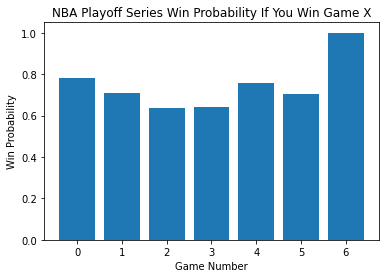

In [81]:
import matplotlib.pyplot as plt
ys = [game_1_p, game_2_p, game_3_p, game_4_p, game_5_p, game_6_p, game_7_p]
xs = list(range(7))
plt.bar(xs, ys)
plt.title("NBA Playoff Series Win Probability If You Win Game X")
plt.xlabel("Game Number")
plt.ylabel("Win Probability")
plt.show()